# Look at bathymetry made using nemo_python

Github: https://github.com/knaughten/nemo_python/

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cmocean
import cartopy.crs as ccrs

import sys
sys.path.append('/users/birgal/nemo_python/')
from constants import region_bounds, region_bathy_bounds

#### Functions

In [3]:
def plot_bathy_diff(bathy_new):
    
    fig, ax = plt.subplots(1,3, figsize=(20,8), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

    vmin=0
    vmax=1000

    for axis in ax.ravel():
        axis.set_extent([-100, -120, -75.5, -71], ccrs.PlateCarree())
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

    kwags1={'cmap':cmocean.cm.deep, 'vmin':vmin, 'vmax':vmax, 'transform':ccrs.PlateCarree()}
    kwags2={'cmap':cmocean.cm.balance, 'vmin':-100, 'vmax':100, 'transform':ccrs.PlateCarree()}

    ax[0].set_title('Old bathymetry', fontsize=12)
    cm1 = ax[0].pcolormesh(nemo.nav_lon, nemo.nav_lat, topo['Bathymetry'], **kwags1)
    CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.03, label='Depth (m)')

    ax[1].set_title('New bathymetry', fontsize=12)
    cm2 = ax[1].pcolormesh(nemo.nav_lon, nemo.nav_lat, bathy_new, **kwags1)
    CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.03, label='Depth (m)')

    ax[2].set_title('New minus old bathymetry', fontsize=12)
    cm3 = ax[2].pcolormesh(nemo.nav_lon, nemo.nav_lat, bathy_new - topo['Bathymetry'], **kwags2)
    CB3 = fig.colorbar(cm3, ax=ax[2], fraction=0.03, label='Depth (m)')

#### Code

In [4]:
folder = '/data/oceans_output/shelf/birgal/bathymetry/'
coordinates_file = f'{folder}coordinates_AIS.nc'
in_file          = f'{folder}eORCA025_BedMachine3_IBCSO_AIS.nc'

In [5]:
### process_topo function

topo = xr.open_dataset(in_file)
if np.count_nonzero(topo['bathy'].isnull()):
    # There are missing points
    if will_splice:
        print('Warning: there are missing points. Hopefully this will be dealt with by your splicing later - check to make sure.')
    else:
        raise Exception('Missing points')
nemo = xr.open_dataset(coordinates_file).squeeze()

# Set masks where they fall between 0 and 1
topo['omask'] = np.round(topo['omask'])
topo['imask'] = np.round(topo['imask'])
    
# Make bathymetry and ice draft positive
# Don't need to mask grounded ice with zeros as NEMO will do that for us (and if coupled ice sheet is active need to know bathymetry of grounded ice)
topo['bathy'] = -topo['bathy']
topo['draft'] = xr.where(topo['imask']==1, -topo['draft'], 0)
# Turn negative values (above sea level) to 0 - they'll never be ocean cells
topo['bathy'] = xr.where(topo['bathy']>0, topo['bathy'], 0)
topo['draft'] = xr.where(topo['draft']>0, topo['draft'], 0)
# Now get bathymetry outside of cavities, masked with zeros where there's grounded or floating ice
topo['Bathymetry'] = xr.where(topo['imask']==0, topo['bathy'], 0)

In [6]:
lon = nemo['nav_lon']
lat = nemo['nav_lat']
bathy = topo['bathy']
omask = topo['omask']

# Southern part: north-south wall
[x_wall, x_wall, ymin, ymax] = region_bounds['bear_ridge_S']
# Find longitude indices closest to the target
i_wall   = abs(lon-x_wall).argmin(axis=1)
wall_pts1 = (lat >= ymin)*(lat <= ymax)*(lon == lon[:,i_wall])
bathy1 = xr.where(wall_pts1, 0, bathy)
omask1 = xr.where(wall_pts1, 0, omask)

# Northern part: select easternmost point shallower than 300m at each latitude
[xmin, xmax, ymin, ymax] = region_bounds['bear_ridge_N']
z_deep = region_bathy_bounds['bear_ridge_N'][0]
z_deep=350;
# Find area of Bear Ridge
wall_pts2 = (lat <= ymax)*(lat >= ymin)*(lon >= xmin)*(lon <= xmax)*(bathy < z_deep)
# Identify maximum longitude grid point for each of these points:
bathy2 = xr.where((lon == lon.where(wall_pts2).max(axis=1)), 0, bathy1)
omask2 = xr.where((lon == lon.where(wall_pts2).max(axis=1)), 0, omask1)

In [10]:
bathy2_new = xr.where(topo['imask']==0, bathy2, 0)

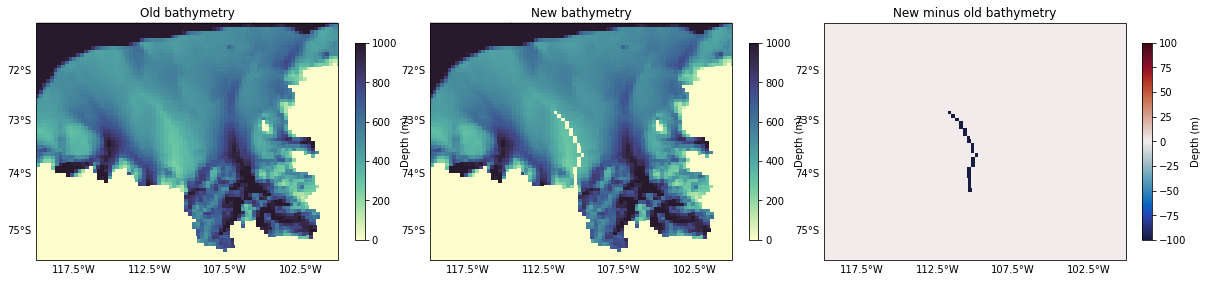

In [12]:
plot_bathy_diff(bathy2_new)